## Modelo de classificação de risco aplicado ao Seguro de Automóvel

Erika Novais Sales Correia <br>
Trabalho de Conclusão de Curso - MBA em Ciência de Dados (CEMEAI)

Objetivo do trabalho é a aplicação dos métodos de classificação: k-vizinhos mais próximos (knn), regressão logística e naive Bayes com foco na análise dos dados de Sinistro de seguro Automóvel (base disponível em: http://www2.susep.gov.br/menuestatistica/autoseg/principal.aspx )
<br>
<br>
<br>




#### Etapa 1 - Carregar Dados e Realizar Tratamento <br>

In [1]:
#carregando bibliotecas
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import seaborn as sns

# define the seed (important to reproduce the results)
random.seed(42) 

# Desativando os avisos sobre as bibliotecas depreciadas:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# carregando dados
data_sin_tot =  pd.read_csv('base/arq_casco_comp_res.csv', header = (0), sep = ';', encoding = 'UTF-8')
data_sin_tot = data_sin_tot.dropna(axis='rows') #remove NaN
print("Quantidade de Linhas Base Completa: ",len(data_sin_tot))

# renomeando colunas de frequencia sinistro e indenização
data_sin_tot.rename(columns={'FREQ_SIN1': 'FREQ_ROUBO', 'INDENIZ1':'INDENIZ_ROUBO',
                             'FREQ_SIN2' : 'FREQ_COL_PARCIAL', 'INDENIZ2':'INDENIZ_COL_PARCIAL',
                             'FREQ_SIN3' : 'FREQ_PERDA_TOTAL', 'INDENIZ3':'INDENIZ_PERDA_TOTAL',
                             'FREQ_SIN4' : 'FREQ_INCENDIO', 'INDENIZ4':'INDENIZ_INCENDIO',
                             'FREQ_SIN9' : 'FREQ_OUTROS', 'INDENIZ9':'INDENIZ_FREQ_OUTROS'}, inplace=True)

#extraindo amostra
data_sin = data_sin_tot.sample(frac=0.05,random_state=60)
print(data_sin)
print("Quantidade de Linhas Base Utilizada: ",len(data_sin))


C:\Users\ERIKA\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Quantidade de Linhas Base Completa:  3058986
         COD_CAT_TARIF  COD_MODELO_GRUPO  ANO_MODELO  IDADE  \
571036               1             23086        2009      2   
1583743              3              1453        2016      5   
43249                2             33100        2014      3   
2538332              3              3139        2010      1   
2356493              4            515134        2012      3   
...                ...               ...         ...    ...   
2260890              1              4339        2009      3   
1444651              3              5508        2019      5   
2882346              1             23123        2018      3   
679442               1             24229        2017      3   
351434               3              3363        2015      0   

                 EXPOSICAO1           PREMIO1          IS_MEDIA  FREQ_ROUBO  \
571036    0,827397227287292  663,547698974609  26765,4571573431           0   
1583743    9,90684905275702  20432,86627

In [2]:
#Criação de colunas auxiliares com valor boolean (SIM/NAO) por tipo de sinistro

data_sin['SINISTRO_ROUBO'] = np.where(data_sin['FREQ_ROUBO'] >= 1, 'SIM','NAO')
data_sin['SINISTRO_COL_PARCIAL'] = np.where(data_sin['FREQ_COL_PARCIAL'] >= 1, 'SIM','NAO')
data_sin['SINISTRO_PER_TOTAL'] = np.where(data_sin['FREQ_PERDA_TOTAL'] >= 1, 'SIM','NAO')
data_sin['SINISTRO_INCENDIO'] = np.where(data_sin['FREQ_INCENDIO'] >= 1, 'SIM','NAO')
data_sin['SINISTRO_OUTROS'] = np.where(data_sin['FREQ_OUTROS'] >= 1, 'SIM','NAO')


#Criação de coluna auxiliar "HOUVE SINISTRO" para verificar se houve sinistro de qualquer natureza

data_sin['HOUVE_SINISTRO'] = np.where((data_sin.FREQ_ROUBO > 0) | (data_sin.FREQ_COL_PARCIAL > 0) 
                                      |(data_sin.FREQ_PERDA_TOTAL > 0) | (data_sin.FREQ_INCENDIO > 0) 
                                      | (data_sin.FREQ_OUTROS > 0) , 'OCORREU_SINISTRO', 'SEM_SINISTRO')

#Criacao coluna "HOUVE_SINISTRO_BIN" com valores binários onde 0 = SEM_SINISTRO e 1 = OCORREU_SINISTRO

data_sin['HOUVE_SINISTRO_BIN'] = np.where((data_sin.FREQ_ROUBO > 0) | (data_sin.FREQ_COL_PARCIAL > 0) 
                                      |(data_sin.FREQ_PERDA_TOTAL > 0) | (data_sin.FREQ_INCENDIO > 0) 
                                      | (data_sin.FREQ_OUTROS > 0) , '1', '0')

print(data_sin)


         COD_CAT_TARIF  COD_MODELO_GRUPO  ANO_MODELO  IDADE  \
571036               1             23086        2009      2   
1583743              3              1453        2016      5   
43249                2             33100        2014      3   
2538332              3              3139        2010      1   
2356493              4            515134        2012      3   
...                ...               ...         ...    ...   
2260890              1              4339        2009      3   
1444651              3              5508        2019      5   
2882346              1             23123        2018      3   
679442               1             24229        2017      3   
351434               3              3363        2015      0   

                 EXPOSICAO1           PREMIO1          IS_MEDIA  FREQ_ROUBO  \
571036    0,827397227287292  663,547698974609  26765,4571573431           0   
1583743    9,90684905275702  20432,8662719727  104063,765086472           0   
43249 

In [3]:
#Colunas e qtde de linhas do df 
list(data_sin.columns)

['COD_CAT_TARIF',
 'COD_MODELO_GRUPO',
 'ANO_MODELO',
 'IDADE',
 'EXPOSICAO1',
 'PREMIO1',
 'IS_MEDIA',
 'FREQ_ROUBO',
 'INDENIZ_ROUBO',
 'FREQ_COL_PARCIAL',
 'INDENIZ_COL_PARCIAL',
 'FREQ_PERDA_TOTAL',
 'INDENIZ_PERDA_TOTAL',
 'FREQ_INCENDIO',
 'INDENIZ_INCENDIO',
 'FREQ_OUTROS',
 'INDENIZ_FREQ_OUTROS',
 'COD_NUM_SEXO',
 'REGIAO',
 'SINISTRO_ROUBO',
 'SINISTRO_COL_PARCIAL',
 'SINISTRO_PER_TOTAL',
 'SINISTRO_INCENDIO',
 'SINISTRO_OUTROS',
 'HOUVE_SINISTRO',
 'HOUVE_SINISTRO_BIN']

In [4]:
#substitui ',' por '.' para permitir transformação float
data_sin = data_sin.replace({',': '.'}, regex=True)

In [5]:
#Remove valores com caracter especial na coluna Região
indexNames = data_sin[ data_sin['REGIAO'] == ' .' ].index
indexNames
data_sin.drop(indexNames , inplace=True)


### Etapa 2 - Análise Exploratória dos dados

NAO    150438
SIM      1935
Name: SINISTRO_ROUBO, dtype: int64


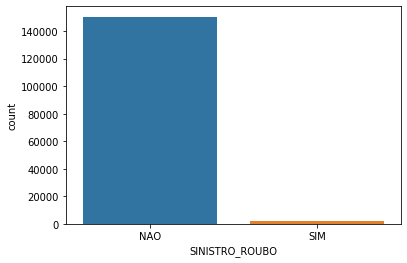

In [6]:
quantidade_sin_roubo = data_sin.SINISTRO_ROUBO.value_counts()
print (quantidade_sin_roubo)
ax_r = sns.countplot(x="SINISTRO_ROUBO", data=data_sin)

NAO    152278
SIM        95
Name: SINISTRO_INCENDIO, dtype: int64


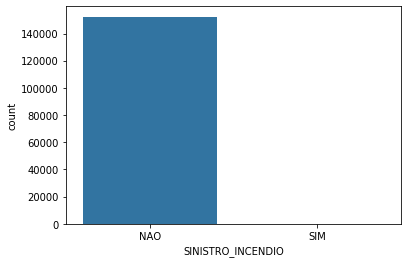

In [7]:
quantidade_sin_incendio = data_sin.SINISTRO_INCENDIO.value_counts()
print (quantidade_sin_incendio)
ax_i = sns.countplot(x="SINISTRO_INCENDIO", data=data_sin)

NAO    139165
SIM     13208
Name: SINISTRO_COL_PARCIAL, dtype: int64


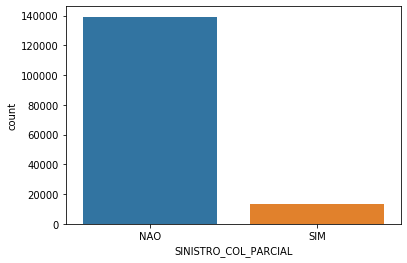

In [8]:
#SINISTRO_COL_PARCIAL  SINISTRO_PER_TOTAL SINISTRO_OUTROS 
quantidade_sin_parcial = data_sin.SINISTRO_COL_PARCIAL.value_counts()
print (quantidade_sin_parcial)
ax_p = sns.countplot(x="SINISTRO_COL_PARCIAL", data=data_sin)


NAO    150003
SIM      2370
Name: SINISTRO_PER_TOTAL, dtype: int64


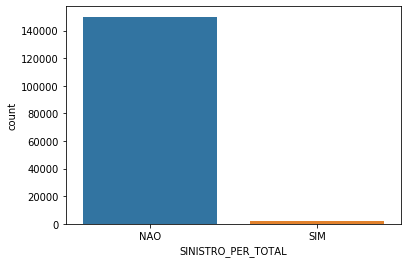

In [9]:
quantidade_sin_total = data_sin.SINISTRO_PER_TOTAL.value_counts()
print (quantidade_sin_total)
ax_t = sns.countplot(x="SINISTRO_PER_TOTAL", data=data_sin)


NAO    126768
SIM     25605
Name: SINISTRO_OUTROS, dtype: int64


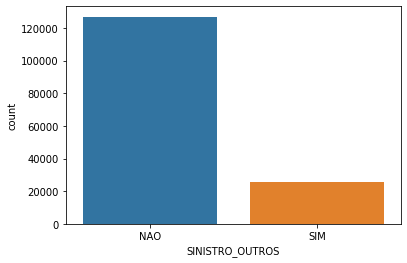

In [10]:
quantidade_sin_outros = data_sin.SINISTRO_OUTROS.value_counts()
print (quantidade_sin_outros)
ax_o = sns.countplot(x="SINISTRO_OUTROS", data=data_sin)


SEM_SINISTRO        120019
OCORREU_SINISTRO     32354
Name: HOUVE_SINISTRO, dtype: int64


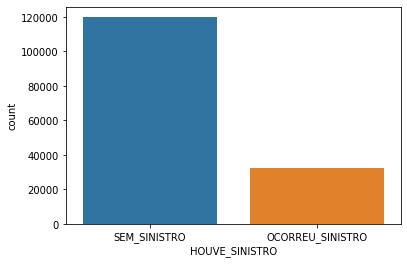

In [11]:
quantidade_sin_geral = data_sin.HOUVE_SINISTRO.value_counts()
print (quantidade_sin_geral)
ax_o = sns.countplot(x="HOUVE_SINISTRO", data=data_sin)

Text(0.5, 1, 'Matriz de correlações de Pearson')

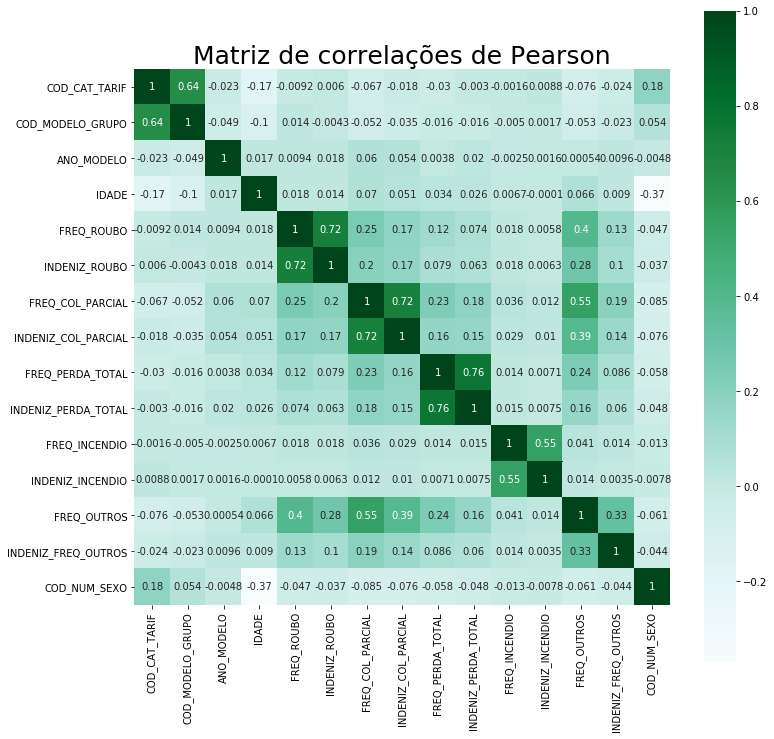

In [12]:
#Matriz de correlações de Pearson
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data_sin.drop(['HOUVE_SINISTRO'], axis=1).corr(),annot=True, square=True, cmap="BuGn")

plt.title('Matriz de correlações de Pearson',fontsize=25)

<br>

### Etapa 3 - Definindo DataFrame para Treinamento e Verificando Balanceamento

In [13]:
#df com resumo das informações utilizadas para treino e teste excluindo as informações "resposta" de Indenização e Sinistro 
data_sin_res = data_sin[['COD_CAT_TARIF', 'REGIAO','ANO_MODELO','IDADE','PREMIO1','IS_MEDIA','COD_NUM_SEXO',
                         'EXPOSICAO1','HOUVE_SINISTRO_BIN']]

list(data_sin_res.columns)
data_sin_res.head(10)

,COD_CAT_TARIF,REGIAO,ANO_MODELO,IDADE,PREMIO1,IS_MEDIA,COD_NUM_SEXO,EXPOSICAO1,HOUVE_SINISTRO_BIN
571036,1,11,2009,2,663.547698974609,26765.4571573431,2.0,0.827397227287292,0
1583743,3,09,2016,5,20432.8662719727,104063.765086472,1.0,9.90684905275702,0
43249,2,18,2014,3,6126.14697265625,165967.006156271,1.0,0.504109561443329,0
2538332,3,13,2010,1,797.22783946991,6281.97479473013,3.0,1.51506843231618,0
2356493,4,07,2012,3,894.645751953125,104106.002822646,3.0,0.287671238183975,0
2074603,3,13,2016,3,4914.80593109131,49117.3703370386,1.0,2.90684919804335,1
3091360,1,8,2016,0,0,0,2.0,0,1
3049066,1,13,2017,0,1559.66564941406,64054.13654268,2.0,1.36438351869583,1
249542,2,18,2018,5,107.994552612305,129911.001377551,2.0,0.0520547963678837,0
622851,1,20,2017,5,2115.85782623291,18969.1711294828,2.0,2.52876706793904,0


In [14]:
print(data_sin_res)

         COD_CAT_TARIF REGIAO  ANO_MODELO  IDADE           PREMIO1  \
571036               1     11        2009      2  663.547698974609   
1583743              3     09        2016      5  20432.8662719727   
43249                2     18        2014      3  6126.14697265625   
2538332              3     13        2010      1   797.22783946991   
2356493              4     07        2012      3  894.645751953125   
...                ...    ...         ...    ...               ...   
2260890              1     06        2009      3  387.103820800781   
1444651              3     11        2019      5  207.615798950195   
2882346              1     23        2018      3  772.765014648438   
679442               1     38        2017      3    994.5107421875   
351434               3     11        2015      0  11772.8968505859   

                 IS_MEDIA  COD_NUM_SEXO          EXPOSICAO1 HOUVE_SINISTRO_BIN  
571036   26765.4571573431           2.0   0.827397227287292                  0

In [15]:
data_sin_res.HOUVE_SINISTRO_BIN.value_counts()

0    120019
1     32354
Name: HOUVE_SINISTRO_BIN, dtype: int64

Balanceamento Dados de Frequência de Sinistro


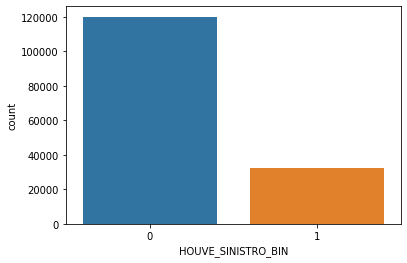

In [16]:
#Demonstra que os dados Não estão balanceados
print ("Balanceamento Dados de Frequência de Sinistro")
ax = sns.countplot(x="HOUVE_SINISTRO_BIN", data=data_sin_res)

In [ ]:
import seaborn as sns
#sns.load_dataset("data_sin")
#sns.pairplot(df, hue="HOUVE_SINISTRO_BIN")

<br>

### Etapa 4 - Separação do conjunto de Treinamento e Teste e Aplicação dos Modelos - Classe DESBALANCEADA

#### 4.1 - Definição do Conjunto de Testes

In [17]:
#Definindo entrada e saída para o Modelo
data_sin_res = data_sin_res.to_numpy()
nrow,ncol = data_sin_res.shape
y = data_sin_res[:,-1]
X = data_sin_res[:,0:ncol-1]



In [18]:
#Definição conjunto de Treino e Teste
from sklearn.model_selection import train_test_split
p = 0.2 # fraction of elements in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p)

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [20]:
print('Dados transformados:',X)
print('Media: ', np.mean(X, axis = 0))
print('Desvio Padrao:', np.std(X, axis = 0))

Dados transformados: [[-0.7016351  -0.46221228 -0.4946394  ... -0.492476    0.30644988
  -0.10656723]
 [ 0.51058854 -0.61378163  0.4186258  ...  0.83570012 -0.98121766
   0.41516017]
 [-0.09552328  0.06828047  0.15769288 ...  1.89935092 -0.98121766
  -0.12514413]
 ...
 [-0.7016351   0.44720385  0.67955871 ...  0.64697187 -0.98121766
  -0.12640358]
 [-0.7016351   1.58397401  0.54909225 ...  0.37461314 -0.98121766
  -0.1249867 ]
 [ 0.51058854 -0.46221228  0.28815934 ...  0.7523896   1.59411742
  -0.01163614]]
Media:  [ 8.20719691e-18 -8.08595423e-17  8.14974653e-15 -4.60255872e-17
 -3.30153148e-17 -3.82847083e-17  7.59165714e-17  1.03522597e-17]
Desvio Padrao: [1. 1. 1. 1. 1. 1. 1. 1.]


### 4.2 - Aplicação dos Classificadores - K-vizinhos mais próximos (KNN), Regressão logística e Naive Bayes (Classes Desbalanceadas)

#### 4.2.1 - Regressão Logística

In [21]:
#Regressão Logistica
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Saída:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.8331091058244463

##### Regressão Logística - Accuracy, F1 Score, Precision e Recall

In [22]:
#Regressão Logística - Accuracy, F1 Score, Precision e Recall
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

print('Accuracy:', accuracy_score(y_pred, y_test))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))
print('Precision:', precision_score(y_test, y_pred, average="macro"))
print('Recall:', recall_score(y_test, y_pred, average="macro"))
print (classification_report(y_test, y_pred))

#Matriz de confusão
print ('Confusion Matrix: ')
print ('   ')
print (pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))


Accuracy: 0.8331091058244463
F1 score: 0.6551219359500409
Precision: 0.8357325261425133
Recall: 0.6274962092082885
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     23977
           1       0.84      0.27      0.41      6498

    accuracy                           0.83     30475
   macro avg       0.84      0.63      0.66     30475
weighted avg       0.83      0.83      0.80     30475

Confusion Matrix: 
   
Predicted      0     1    All
True                         
0          23641   336  23977
1           4750  1748   6498
All        28391  2084  30475


In [ ]:
#import matplotlib.pyplot as plt
#from sklearn.datasets import make_classification
#from sklearn.metrics import plot_confusion_matrix
#from sklearn.model_selection import train_test_split
#from sklearn.svm import SVC

#clf = LogisticRegression()
#clf.fit(X_train, y_train)
#SVC(random_state=0)
#plot_confusion_matrix(clf, X_test, y_test)  
#plt.show()

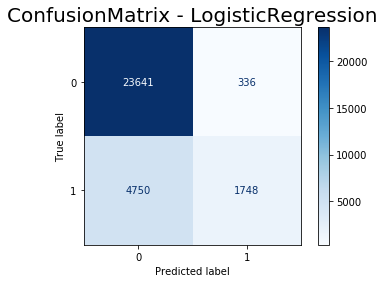

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay

clf = LogisticRegression()
clf.fit(X_train, y_train)
SVC(random_state=0)

disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Blues)
plt.title('ConfusionMatrix - LogisticRegression',fontsize=20)

plt.show()

<br>

#### 4.2.2 - K-vizinhos mais próximos (KNN)

In [24]:
#K-vizinhos
from sklearn.neighbors import KNeighborsClassifier
k = 5 # numero de vizinhos
# ajusta o modelo k-vizinhos
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X_train,y_train)
# faz a predição no conjunto de teste
y_pred = model.predict(X_test) 

In [25]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.8255291222313371


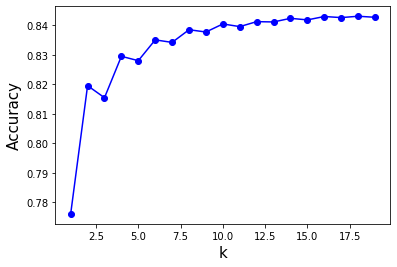

Melhor k: 18


In [26]:
#Definição do melhor valor para K
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

nkf = 5 #number of folds
vk = [] # armazena os valores de k
vscore = []
for k in range(1, 20):
    model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    # realiza a validação cruzada
    cv = cross_validate(model, X_train, y_train, cv=nkf)
    #print('k:', k, 'accurace:', cv['test_score'].mean())
    vscore.append(cv['test_score'].mean()) 
    vk.append(k)

plt.plot(vk, vscore, '-bo')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show(True)
best_k = np.argmax(vscore)+1
print('Melhor k:', best_k)

In [27]:
from sklearn.metrics import accuracy_score
model = KNeighborsClassifier(n_neighbors=best_k, metric = 'euclidean')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_pred, y_test))

Accuracy: 0.8389171452009844


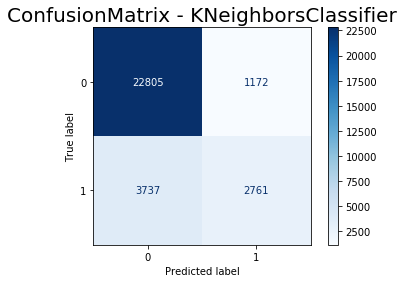

In [28]:


clf = model.fit(X_train, y_train)
#SVC(random_state=0)

disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Blues)
plt.title('ConfusionMatrix - KNeighborsClassifier',fontsize=20)

plt.show()

##### K-vizinhos mais próximos (KNN) - Accuracy, F1 Score, Precision e Recall

In [29]:
#K-vizinhos mais próximos (KNN) - Accuracy, F1 Score, Precision e Recall
from sklearn.metrics import confusion_matrix

print('Accuracy:', accuracy_score(y_pred, y_test))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))
print('Precision:', precision_score(y_test, y_pred, average="macro"))
print('Recall:', recall_score(y_test, y_pred, average="macro"))
print (classification_report(y_test, y_pred))

#Matriz de confusão
print ('Confusion Matrix: ')
print ('  ')
print (pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.8389171452009844
F1 score: 0.7161061034700628
Precision: 0.7806064624047245
Recall: 0.6880098961925821
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     23977
           1       0.70      0.42      0.53      6498

    accuracy                           0.84     30475
   macro avg       0.78      0.69      0.72     30475
weighted avg       0.83      0.84      0.82     30475

Confusion Matrix: 
  
Predicted      0     1    All
True                         
0          22805  1172  23977
1           3737  2761   6498
All        26542  3933  30475


#### 4.2.3 - Naive Bayes

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('Accuracy: ', model.score(X_test, y_test))

Accuracy:  0.8199179655455291


##### Naive Bayes - Accuracy, F1 Score, Precision e Recall

In [31]:
# Naive Bayes - Accuracy, F1 Score, Precision e Recall

print('Accuracy:', accuracy_score(y_pred, y_test))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))
print('Precision:', precision_score(y_test, y_pred, average="macro"))
print('Recall:', recall_score(y_test, y_pred, average="macro"))
print (classification_report(y_test, y_pred))
#Matriz de confusão
print ('Confusion Matrix: ')
print (' ')
print (pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.8199179655455291
F1 score: 0.5973701336513104
Precision: 0.849828437868654
Recall: 0.5864107028135471
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     23977
           1       0.88      0.18      0.30      6498

    accuracy                           0.82     30475
   macro avg       0.85      0.59      0.60     30475
weighted avg       0.83      0.82      0.77     30475

Confusion Matrix: 
 
Predicted      0     1    All
True                         
0          23822   155  23977
1           5333  1165   6498
All        29155  1320  30475


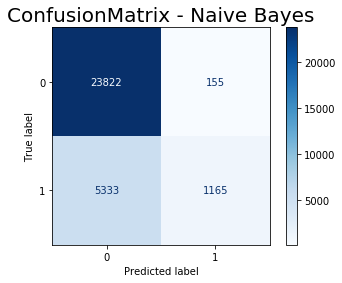

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

clf = model.fit(X_train, y_train)
#SVC(random_state=0)

disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Blues)
plt.title('ConfusionMatrix - Naive Bayes',fontsize=20)

plt.show()

### Etapa 5 - Ajuste Classes Desbalanceadas (NearMiss) 

In [33]:
#Ajustando classes desbalanceadas
from imblearn.under_sampling import NearMiss 
#Aplicando NearMiss:
nr = NearMiss()

In [34]:
X, y = nr.fit_sample(X, y)

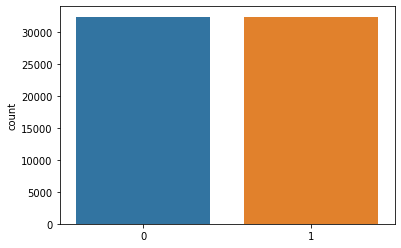

In [35]:
ax = sns.countplot(x=y)

### Etapa 6 - Separação do conjunto de Treinamento e Teste e Aplicação dos Modelos

#### 6.1 - Definição do Conjunto de Testes

In [36]:
from sklearn.model_selection import train_test_split
p = 0.2 # fraction of elements in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p)

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [38]:
print('Dados transformados:',X)
print('Media: ', np.mean(X, axis = 0))
print('Desvio Padrao:', np.std(X, axis = 0))

Dados transformados: [[-0.44124958 -0.83428736 -0.55790394 ... -0.40790806 -0.90827919
  -0.32884404]
 [-0.44124958 -0.37017782 -1.40625775 ... -0.75610569 -0.90827919
  -0.29354546]
 [-0.44124958  1.64096349 -0.55790394 ... -0.5684708  -0.90827919
  -0.31498448]
 ...
 [-0.44124958  0.94479919  0.71462678 ... -0.01112026  1.10098305
  -0.28228456]
 [ 0.59318191 -0.44752941  0.07836142 ... -0.41322724 -0.90827919
  -0.31498448]
 [-0.44124958  1.71831508  0.50253832 ... -0.23934665 -0.90827919
   0.02522453]]
Media:  [-3.06380187e-13 -4.04908501e-16  4.02216500e-15 -7.15266176e-15
  7.15361400e-15 -2.43847912e-14  7.99328322e-14 -8.25740814e-15]
Desvio Padrao: [1. 1. 1. 1. 1. 1. 1. 1.]


### 6.2 - Aplicação dos Classificadores - K-vizinhos mais próximos (KNN), Regressão logística e Naive Bayes 

#### 6.2.1 - Regressão Logística

In [40]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Saída:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
y_pred = lr.predict(X_test)
y_pred_lr = y_pred
accuracy_score(y_test, y_pred)

0.7797094730335342

##### Regressão Logística - Accuracy, F1 Score, Precision e Recall

In [41]:
print('Accuracy:', accuracy_score(y_pred, y_test))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))
print('Precision:', precision_score(y_test, y_pred, average="macro"))
print('Recall:', recall_score(y_test, y_pred, average="macro"))
print (classification_report(y_test, y_pred))

#Matriz de confusão
print ('Confusion Matrix: ')
print (' ')
print (pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.7797094730335342
F1 score: 0.7778279473128118
Precision: 0.7878046744442662
Recall: 0.7789714192775116
              precision    recall  f1-score   support

           0       0.74      0.86      0.80      6527
           1       0.83      0.69      0.76      6415

    accuracy                           0.78     12942
   macro avg       0.79      0.78      0.78     12942
weighted avg       0.79      0.78      0.78     12942

Confusion Matrix: 
 
Predicted     0     1    All
True                        
0          5641   886   6527
1          1965  4450   6415
All        7606  5336  12942


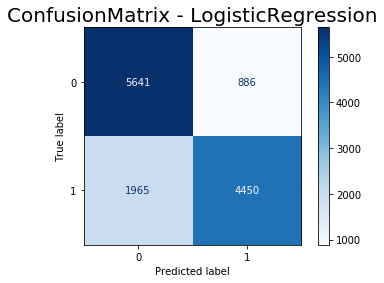

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

clf = LogisticRegression()
clf.fit(X_train, y_train)
#SVC(random_state=0)

disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Blues)
plt.title('ConfusionMatrix - LogisticRegression',fontsize=20)

plt.show()

<br>

#### 6.2.2 - K-vizinhos mais próximos (KNN)

In [44]:
#K-vizinhos
from sklearn.neighbors import KNeighborsClassifier
k = 5 # numero de vizinhos
# ajusta o modelo k-vizinhos
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X_train,y_train)
# faz a predição no conjunto de teste
y_pred = model.predict(X_test) 
y_pred_knn = model.predict(X_test) 
print ()

In [45]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.7535156853654768


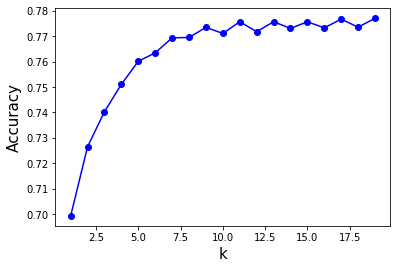

Melhor k: 19


In [46]:
#Definição do melhor valor para K
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

nkf = 5 #number of folds
vk = [] # armazena os valores de k
vscore = []
for k in range(1, 20):
    model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    # realiza a validação cruzada
    cv = cross_validate(model, X_train, y_train, cv=nkf)
    #print('k:', k, 'accurace:', cv['test_score'].mean())
    vscore.append(cv['test_score'].mean()) 
    vk.append(k)

plt.plot(vk, vscore, '-bo')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show(True)
best_k = np.argmax(vscore)+1
print('Melhor k:', best_k)

In [47]:
from sklearn.metrics import accuracy_score
model = KNeighborsClassifier(n_neighbors=best_k, metric = 'euclidean')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_knn = y_pred
print('Accuracy:', accuracy_score(y_pred, y_test))

Accuracy: 0.7773914387266265


##### K-vizinhos mais próximos (KNN) - Accuracy, F1 Score, Precision e Recall

In [48]:
print('Accuracy:', accuracy_score(y_pred, y_test))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))
print('Precision:', precision_score(y_test, y_pred, average="macro"))
print('Recall:', recall_score(y_test, y_pred, average="macro"))
print (classification_report(y_test, y_pred))

#Matriz de confusão
print ('Confusion Matrix: ')
print (' ')
print (pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.7773914387266265
F1 score: 0.7738701621840863
Precision: 0.7933774658142714
Recall: 0.7763696718266386
              precision    recall  f1-score   support

           0       0.73      0.89      0.80      6527
           1       0.86      0.66      0.75      6415

    accuracy                           0.78     12942
   macro avg       0.79      0.78      0.77     12942
weighted avg       0.79      0.78      0.77     12942

Confusion Matrix: 
 
Predicted     0     1    All
True                        
0          5838   689   6527
1          2192  4223   6415
All        8030  4912  12942


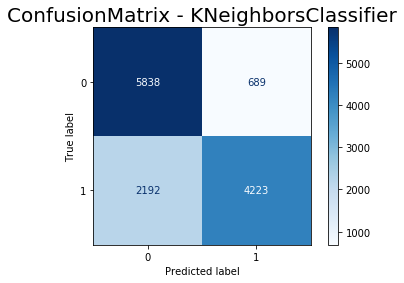

In [49]:
clf = model.fit(X_train, y_train)
#SVC(random_state=0)

disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Blues)
plt.title('ConfusionMatrix - KNeighborsClassifier',fontsize=20)

plt.show()

#### 6.2.3 - Naive Bayes

In [50]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_nb = y_pred
print('Accuracy: ', model.score(X_test, y_test))

Accuracy:  0.7556791840519239


##### Naive Bayes - Accuracy, F1 Score, Precision e Recall

In [51]:
print('Accuracy:', accuracy_score(y_pred, y_test))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))
print('Precision:', precision_score(y_test, y_pred, average="macro"))
print('Recall:', recall_score(y_test, y_pred, average="macro"))
print (classification_report(y_test, y_pred))

#Matriz de confusão
print ('Confusion Matrix: ')
print (' ')
print (pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.7556791840519239
F1 score: 0.7459234420926212
Precision: 0.7977548971276311
Recall: 0.7540398949575844
              precision    recall  f1-score   support

           0       0.69      0.94      0.80      6527
           1       0.91      0.56      0.70      6415

    accuracy                           0.76     12942
   macro avg       0.80      0.75      0.75     12942
weighted avg       0.80      0.76      0.75     12942

Confusion Matrix: 
 
Predicted     0     1    All
True                        
0          6158   369   6527
1          2793  3622   6415
All        8951  3991  12942


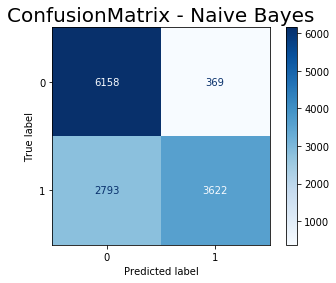

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay

clf = model.fit(X_train, y_train)
SVC(random_state=0)

disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Blues)
plt.title('ConfusionMatrix - Naive Bayes',fontsize=20)

plt.show()

<br>

### 7 - Curva ROC

No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.754
Logistic: ROC AUC=0.779
KNN: ROC AUC=0.776


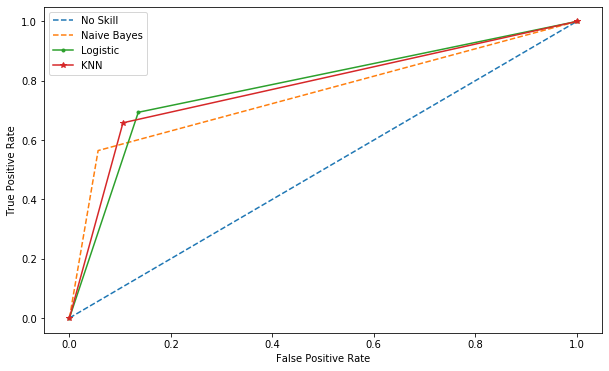

In [53]:
#comparativo entre 3 modelos de ROC_CURVE

from sklearn.metrics import roc_curve


# roc curve and auc
from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt 


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


y_pred_nb = y_pred_nb.astype('int32')
y_pred_lr = y_pred_lr.astype('int32')
y_pred_knn = y_pred_knn.astype('int32')
y_test = y_test.astype('int32')

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

#conversão para int
y_pred_nb = y_pred_nb.astype('int32')
y_pred_lr = y_pred_lr.astype('int32')
y_pred_knn = y_pred_knn.astype('int32')
y_test = y_test.astype('int32')


# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
nb_auc = roc_auc_score(y_test, y_pred_nb)
lr_auc = roc_auc_score(y_test, y_pred_lr)
tr_auc = roc_auc_score(y_test, y_pred_knn) #DecicionTree

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (nb_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('KNN: ROC AUC=%.3f' % (tr_auc)) #DecicionTree




# calculate roc curves
nb_fpr, nb_tpr, _ = roc_curve(y_test, y_pred_nb)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred_lr)
tr_fpr, tr_tpr, _ = roc_curve(y_test, y_pred_knn) 
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

# plot the roc curve for the model

plt.figure(figsize=(10,6))
ax = plt.axes() 
#ax.set_facecolor("white") 
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(nb_fpr, nb_tpr, linestyle='--', label='Naive Bayes')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(tr_fpr, tr_tpr, marker='*', label='KNN')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
data_sin_res.head(10)